# Libraries

In [1]:
import pickle   
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from datetime import datetime
import numpy as np
import re 
from textblob import TextBlob

# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

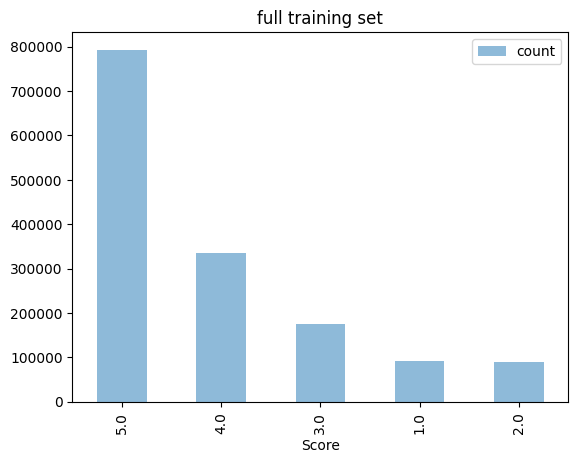


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


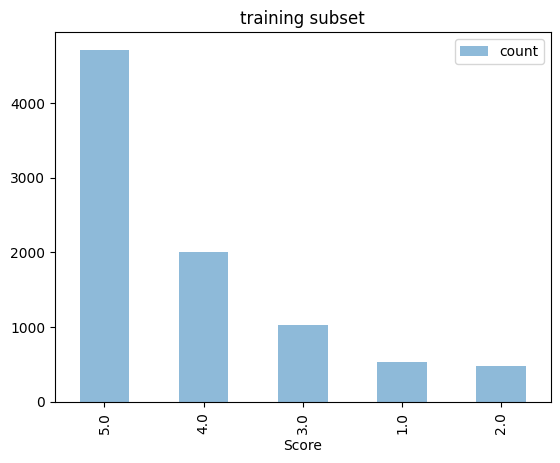

In [2]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")
# Sample 10,000 rows randomly from the training set
subset_train = trainingSet.sample(n=10000, random_state=42)

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()


print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())
print(subset_train.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.title('full training set')
plt.show()
subset_train['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.title('training subset')

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

Visualizing Data

In [4]:
def clean_data(df):
#drop NaN values from score column
    df = df.dropna(subset=['Score']) 
    #drop irrelevant columns
    # df = df.drop(columns=['UserId'])

    #maybe drop productid and userid after extracting some features 

    #handle helpfulness denominator of 0 
    df['Helpfulness'] = np.where(df['HelpfulnessDenominator'] == 0, 0, 
                                        df['HelpfulnessNumerator'] / df['HelpfulnessDenominator'])
    df['Helpfulness'] = df['Helpfulness'].fillna(0) #replace 0 with na 

    #convert unix to datetime
    df['Time'] = pd.to_datetime(df['Time'], unit='s')

    #extract time features 
    df['Year'] = df['Time'].dt.year
    df['Month'] = df['Time'].dt.month
    df['DayOfWeek'] = df['Time'].dt.dayofweek
    # Convert 'Time' column from string to datetime
    df.drop(columns=['Time'], inplace=True)

    # Fill missing values in 'Summary' and 'Text' columns
    df['Summary'].fillna('No summary', inplace=True)
    df['Text'].fillna('No text', inplace=True)

    # Apply text cleaning
    df['CleanedText'] = df['Text'].apply(lambda x: clean_text(x) if isinstance(x, str) else '')
    df['CleanedSummary'] = df['Summary'].apply(lambda x: clean_text(x) if isinstance(x, str) else '')

    # Check for null values
    print("Missing values after processing:")
    print(df.isnull().sum())

#clean text 
def clean_text(text):
    # Remove punctuation, convert to lowercase
    text = re.sub(r'[^\w\s]', '', text.lower())
    return text

cleaned_train = clean_data(trainingSet)

# Save the cleaned DataFrame as a pickle file
with open('./data/cleaned_train.pkl', 'wb') as f:
    pickle.dump(cleaned_train, f)



/var/folders/mw/d6jh5r755yj5xb4v20prr1g00000gn/T/ipykernel_3099/3979278057.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Helpfulness'] = np.where(df['HelpfulnessDenominator'] == 0, 0,
/var/folders/mw/d6jh5r755yj5xb4v20prr1g00000gn/T/ipykernel_3099/3979278057.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Helpfulness'] = df['Helpfulness'].fillna(0) #replace 0 with na
/var/folders/mw/d6jh5r755yj5xb4v20prr1g00000gn/T/ipykernel_3099/3979278057.py:15: SettingWithCopyWarning: 
A value is tryi

Missing values after processing:
Id                        0
ProductId                 0
UserId                    0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Summary                   0
Text                      0
Score                     0
Helpfulness               0
Year                      0
Month                     0
DayOfWeek                 0
CleanedText               0
CleanedSummary            0
dtype: int64


# Adding Features

In [4]:
from textblob import TextBlob
import os 



def add_features_to(df):
    # This is where you can do all your feature extraction
    df['TextLength'] = df['Text'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
    df['SummaryLength'] = df['Summary'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)
    
    #number exclamation marks to indicate enthusiasm / emotions
    df['ExclamationMarks'] = df['Text'].apply(lambda x: x.count('!') if isinstance(x, str) else 0)
    #number of question marks = confusion
    df['QuestionMarks'] = df['Text'].apply(lambda x: x.count('?') if isinstance(x, str) else 0)

    # Sentiment polarity using simple heuristics (positive or negative words)
    positive_words = ['good', 'great', 'excellent', 'amazing', 'love', 'fantastic', 'awesome']
    negative_words = ['bad', 'terrible', 'awful', 'poor', 'worst', 'hate', 'boring']

    df['PositiveWords'] = df['Text'].apply(lambda x: sum(1 for word in x.split() if word.lower() in positive_words) if isinstance(x, str) else 0)
    df['NegativeWords'] = df['Text'].apply(lambda x: sum(1 for word in x.split() if word.lower() in negative_words) if isinstance(x, str) else 0)

    # Review sentiment score: positive - negative word count
    df['SentimentScore'] = df['PositiveWords'] - df['NegativeWords']
    df['HasUppercaseWord'] = df['Text'].apply(lambda x: any(word.isupper() for word in x.split()) if isinstance(x, str) else 0)

    df['SentimentPolarity'] = df['Text'].apply(get_sentiment)
    df['VocabularyRichness'] = df['Text'].apply(vocabulary_richness)
    df['ReviewLength'] = df['Text'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)


    return df


# Define a function to calculate sentiment polarity
def get_sentiment(text):
    if isinstance(text, str):  # Check if text is a valid string
        return TextBlob(text).sentiment.polarity
    return 0  # Return 0 for missing or invalid text entries

def vocabulary_richness(text):
    if isinstance(text, str):
        words = text.split()
        unique_words = set(words)
        return len(unique_words) / len(words) if len(words) > 0 else 0
    return 0


# Load the feature extracted files if they've already been generated
if os.path.exists('./data/X_train.pkl') and os.path.exists('./data/X_submission.pkl'):
    with open('./data/X_train.pkl', 'rb') as f:
        X_train = pickle.load(f)
    with open('./data/X_submission.pkl', 'rb') as f:
        X_submission = pickle.load(f)
else:
    train = add_features_to(trainingSet)
    X_submission = pd.merge(trainingSet, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})
    X_train = train[train['Score'].notnull()]

    # Save with pickle
    with open('./data/X_train.pkl', 'wb') as f:
        pickle.dump(X_train, f)
    with open('./data/X_submission.pkl', 'wb') as f:
        pickle.dump(X_submission, f)

# Sample + Split into training and testing set

In [5]:
# Split training set into training and testing set

X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)

In [155]:
print(X_train.head())

              Id   ProductId          UserId  HelpfulnessNumerator  \
194235   1469849  B005LAIHCW  A1X28ARLHYQQXU                     0   
431280   1330111  B00382S9MS  A22GI2VTY0RRJO                     1   
14846    1578052  B008XB2UCE  A1HHU3I9M83YBV                     3   
556988    131129  0792164903  A2B73CL3QSYWLB                     0   
1023198   121923  0790776960   A82LIVYSX6WZ9                     1   

         HelpfulnessDenominator        Time  \
194235                        0  1381276800   
431280                        1  1403568000   
14846                         3  1392595200   
556988                        3  1319846400   
1023198                       5  1065657600   

                                              Summary  \
194235                            Scary with a twist!   
431280                                  Action Impact   
14846                         Best of Naked City DVDs   
556988   Headless Horseman Undone By Brainless Script   
1023198    

# Feature Selection

In [9]:
from sklearn.decomposition import PCA
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import StandardScaler

# Define feature columns
features = [
    'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Helpfulness', 
    'ExclamationMarks', 'QuestionMarks', 'PositiveWords', 'NegativeWords', 
    'SentimentScore', 'HasUppercaseWord', 'SentimentPolarity', 'VocabularyRichness', 'ReviewLength'
]

# Select features from original dataset and fill any missing values
X_train_select = X_train[features].fillna(0)
X_test_select = X_test[features].fillna(0)
X_submission_select = X_submission[features].fillna(0)

# Convert boolean column to integer in a copy to avoid SettingWithCopyWarning
for df in [X_train_select, X_test_select, X_submission_select]:
    df = df.copy()
    df['HasUppercaseWord'] = df['HasUppercaseWord'].astype(int)

# Subsample the data (example: 10% of the original data)
subsample = X_train_select.sample(frac=0.1, random_state=42)
Y_subsample = Y_train.loc[subsample.index]

scaler = StandardScaler()
X_subsample_scaled = scaler.fit_transform(subsample)
# X_resampled, Y_resampled = SMOTEENN(random_state=42).fit_resample(X_subsample_scaled, Y_subsample)
X_test_scaled = scaler.transform(X_test_select)


'''
# Scale the data before applying SMOTEENN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_select)
X_test_scaled = scaler.transform(X_test_select)

# Apply SMOTEENN on the scaled data
X_resampled, Y_resampled = SMOTEENN(random_state=42).fit_resample(X_train_scaled, Y_train)

# Visualize the balanced class distribution
Y_resampled.value_counts().plot(kind='bar', legend=True, alpha=0.5)
plt.title('Balanced Training Set')
plt.show()
'''
# Save the balanced dataset as a pickle file
with open('balanced_training_data.pkl', 'wb') as f:
    pickle.dump((X_resampled, Y_resampled), f)




# Model Creation

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import GridSearchCV


# Define range of k values to test
k_values = list(range(1, 20))
cv_scores = []

# Cross-validation for each k
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_subsample_scaled, Y_subsample, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Find best k
best_k = k_values[cv_scores.index(max(cv_scores))]
print(f"Best k: {best_k}")

# Plot cross-validation results
plt.plot(k_values, cv_scores, marker='o')
plt.xlabel('k')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Accuracy vs k (KNN)')
plt.show()
''' 
param_grid = {
    'n_neighbors': list(range(1, 21)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_subsample_scaled, Y_train)
best_knn = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)
''' 
# Train KNN model with best k and evaluate on test set
knn_model = KNeighborsClassifier(n_neighbors=best_k).fit(X_subsample_scaled, Y_subsample)
Y_test_predictions_knn = knn_model.predict(X_test_scaled)
# Y_test_predictions_knn = knn_model.predict(X_resampled)


# Print classification report for KNN
print("Classification Report for KNN Model:")
print(classification_report(Y_test, Y_test_predictions_knn))

'''
# Train Random Forest on resampled data and predict on test set
random_forest = RandomForestClassifier(class_weight='balanced', random_state=42)
random_forest.fit(X_resampled, Y_resampled)
Y_test_predictions_rf = random_forest.predict(X_test_select)

# Classification report for Random Forest
print("\nClassification Report for Random Forest Model:")
print(classification_report(Y_test, Y_test_predictions_rf))

# Feature importance analysis
feature_importances = random_forest.feature_importances_
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances from Random Forest:")
print(importance_df)
'''




KeyboardInterrupt: 

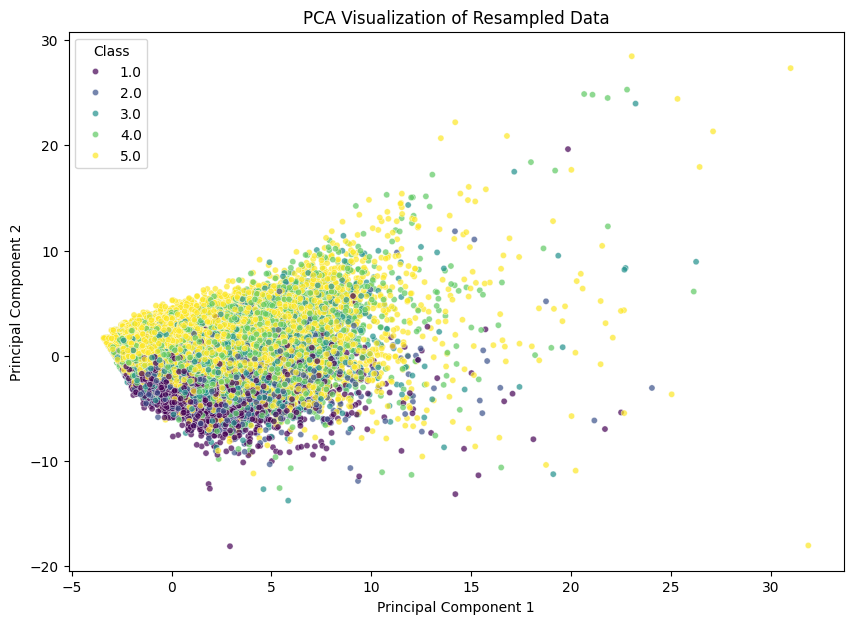

'\n# Reduce the dimensions of the data to 2D using t-SNE\ntsne = TSNE(n_components=2, random_state=42)\nX_resampled_tsne = tsne.fit_transform(X_resampled)\n\n# Plot the t-SNE-transformed data\nplt.figure(figsize=(10, 7))\nsns.scatterplot(x=X_resampled_tsne[:, 0], y=X_resampled_tsne[:, 1], hue=Y_resampled, palette=\'viridis\', s=20, alpha=0.7)\nplt.title("t-SNE Visualization of Resampled Data")\nplt.xlabel("t-SNE Dimension 1")\nplt.ylabel("t-SNE Dimension 2")\nplt.legend(title=\'Class\')\nplt.show()\n'

In [12]:
#plot data distribution
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Reduce the dimensions of the data to 2D using PCA
pca = PCA(n_components=2)
X_resampled_pca = pca.fit_transform(X_test_scaled)

# Plot the PCA-transformed data
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_resampled_pca[:, 0], y=X_resampled_pca[:, 1], hue=Y_test, palette='viridis', s=20, alpha=0.7)
plt.title("PCA Visualization of Resampled Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Class')
plt.show()

'''
# Reduce the dimensions of the data to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_resampled_tsne = tsne.fit_transform(X_resampled)

# Plot the t-SNE-transformed data
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_resampled_tsne[:, 0], y=X_resampled_tsne[:, 1], hue=Y_resampled, palette='viridis', s=20, alpha=0.7)
plt.title("t-SNE Visualization of Resampled Data")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title='Class')
plt.show()
'''


# Model Evaluation

Accuracy on testing set =  0.5384503522416356


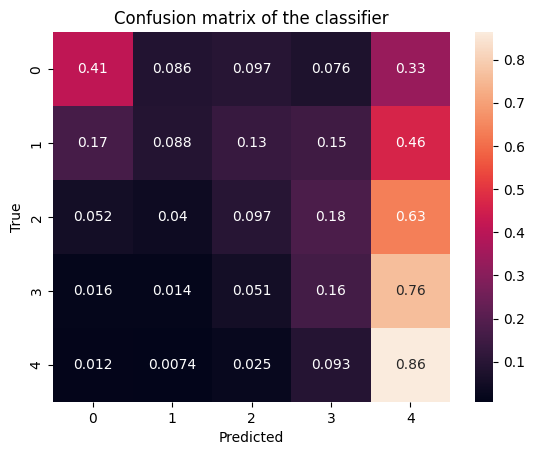

In [13]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions_knn))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions_knn, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [14]:
# Create the submission file
X_submission['Score'] = knn_model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
print("submission.csv shape is ", submission.shape)

submission.to_csv("./data/submission.csv", index=False)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


submission.csv shape is  (212192, 2)
